In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Table of Contents

# References

move this later

1.  https://www.webmd.com/heart-disease/default.htm
2.  https://www.webmd.com/cholesterol-management/default.htm

# Background

Heart disease is "is the leading cause of death for men and women in the U.S."1  And, having high cholesterol is a major risk factor for heart disease.2  The goal of my project is to try to use NHANES survey data to predict total cholesterol level.  A model that predicts total cholesterol level from health information would be benificial to health apps.  If a fittness/health app can predict total cholesterol level, they can notify the user if their cholesterol level is high, promoting they see a doctor and hence reduce heart disease risk.

## note to self, may want to expand


# Data

The National Health and Nutrition Examination Survey is a yearly health exam and survey conducted by the CDC to gauge the overall health status of US citizens.  Each survey consists of multiple datasets in SAS format.

The data I chose to use comes from the 2013-2016 surveys.  Prior and posterior to those years, some variables changed which would make it difficult to combine the data.


The list of vaariables I chose to include for modeling can be seen below.

In [2]:
variables = pd.read_csv('variables.csv')
variables

,Dataset_Description,Variable_Name,Variable_Description
0,LabCholesterolTotal,SEQN,Participant Identification Number
1,LabCholesterolTotal,LBXTC,Total Cholesterol Level
2,FastingQuestionairre,PHAFSTHR,Hours Fasted for labs
3,Demographics,RIAGENDR,Gender
4,Demographics,RIDRETH3,Race
5,Demographics,RIDAGEYR,Age
6,BodyMeasuresExamination,BMXWT,Weight
7,BodyMeasuresExamination,BMXHT,Height
8,BodyMeasuresExamination,BMXBMI,BMI
9,BloodPressureExaminationData,BPXSY1,Systolic1




The reasons for chosing these variables are...

## notes
later want to say you only used first day nutrition
may want to change variables to only include recreation info and say why you only used recreational activity info

In [3]:
data_path = Path("Data/df.csv")
if data_path.is_file():
    df = pd.read_csv("Data/df.csv")
    df.drop('Unnamed: 0',axis=1,inplace=True)
else:
    file_list = pd.read_csv('files.csv')
    years = file_list.Year.unique()
    dfs = [None]*2
    for i in range(len(years)):
        files = file_list[file_list.Year == years[i]]
        first = files[files.Notes=="read in first"]
        first_path = list(first["Path"])[0]
        first_type = list(first["Dataset_Description"])[0]
        first_variables = list(variables[variables.Dataset_Description==first_type]["Variable_Name"])
        df = pd.read_sas(first_path)
        df = df[first_variables].copy()
        others = files[files.Notes!="read in first"]
        for other_path in others["Path"]:
            other_type = list(others[others["Path"]==other_path]["Dataset_Description"])[0]
            temp_df = pd.read_sas(other_path)
            other_variables = ["SEQN"] + list(variables[variables.Dataset_Description==other_type]["Variable_Name"])
            temp_df = temp_df[other_variables].copy()
            df = df.merge(temp_df, on="SEQN", how="left")
        df.drop("SEQN", axis=1, inplace=True)
        dfs[i] = df.copy()
    df = pd.concat(dfs,ignore_index=True)
    df.to_csv("Data/df.csv")
df.head()


,LBXTC,PHAFSTHR,RIAGENDR,RIDRETH3,RIDAGEYR,BMXWT,BMXHT,BMXBMI,BPXSY1,BPXSY2,...,MCQ160M,MCQ170M,SMQ681,PAQ650,PAQ655,PAD660,PAQ665,PAQ670,PAD675,KIQ022
0,173.0,3.0,1.0,3.0,62.0,94.8,184.5,27.8,128.0,124.0,...,2.0,NaN,2.0,2.0,NaN,NaN,1.0,6.0,30.0,NaN
1,265.0,12.0,1.0,3.0,53.0,90.4,171.4,30.8,146.0,140.0,...,2.0,NaN,1.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
2,229.0,10.0,1.0,3.0,78.0,83.4,170.1,28.8,138.0,132.0,...,1.0,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
3,174.0,2.0,2.0,3.0,56.0,109.8,160.9,42.4,132.0,134.0,...,2.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN
4,204.0,10.0,2.0,4.0,42.0,55.2,164.9,20.3,100.0,114.0,...,2.0,NaN,1.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN


## Initial data cleaning

As we are only interested in those that had their Cholesterol level checked, I'm filtering for those without cholesterol level missing. I am also filtering for those age 20 and those who fasted at least 9 hours. As I do not plan to use fasting time in my model, it will be dropped.

# need to explain why for age, fasting, and dropping fasting

In [4]:
df=df[(df.LBXTC.notnull())&(df.PHAFSTHR>=9)&(df.RIDAGEYR>=20)].copy()
df.shape

(5003, 56)

Some questions on survey data get skipped given a certain response to a prior question.  For example, if a person has not been diagnosed with high blood pressure, then they will not be asked if they are taking medication for blood pressure.  Because of this there are more missing values than needed.  Before observing the amount of missing data, these missing values will be fixed.

Also for survey data, there are answers of do not know or refuse to answer, these will be turned into NaNs.

### Blood Pressure/Cholesterol Questionnaire

For those that have never been told they have high blood pressure or high cholesterol I'm setting the taking prescription medication questions to a value of 2, meaning no.

In [5]:
df.loc[df.BPQ020==2,'BPQ040A']=2
df.loc[df.BPQ020==2,'BPQ050A']=2
df.loc[df.BPQ020==7,'BPQ020']=np.nan
df.loc[df.BPQ020==9,'BPQ020']=np.nan
df.loc[df.BPQ020==7,'BPQ040A']=np.nan
df.loc[df.BPQ020==7,'BPQ050A']=np.nan
df.loc[df.BPQ020==9,'BPQ040A']=np.nan
df.loc[df.BPQ020==9,'BPQ050A']=np.nan
df.loc[df.BPQ040A==7,'BPQ040A']=np.nan
df.loc[df.BPQ040A==7,'BPQ050A']=np.nan
df.loc[df.BPQ040A==9,'BPQ040A']=np.nan
df.loc[df.BPQ040A==9,'BPQ050A']=np.nan
df.loc[df.BPQ050A==7,'BPQ050A']=np.nan
df.loc[df.BPQ050A==9,'BPQ050A']=np.nan

df.loc[df.BPQ080==2,'BPQ090D']=2
df.loc[df.BPQ080==2,'BPQ100D']=2
df.loc[df.BPQ080==7,'BPQ080']=np.nan
df.loc[df.BPQ080==9,'BPQ080']=np.nan
df.loc[df.BPQ080==7,'BPQ090D']=np.nan
df.loc[df.BPQ080==7,'BPQ100D']=np.nan
df.loc[df.BPQ080==9,'BPQ090D']=np.nan
df.loc[df.BPQ080==9,'BPQ100D']=np.nan
df.loc[df.BPQ090D==7,'BPQ090D']=np.nan
df.loc[df.BPQ090D==7,'BPQ100D']=np.nan
df.loc[df.BPQ090D==9,'BPQ090D']=np.nan
df.loc[df.BPQ090D==9,'BPQ100D']=np.nan
df.loc[df.BPQ100D==7,'BPQ100D']=np.nan
df.loc[df.BPQ100D==9,'BPQ100D']=np.nan

### Diabetes Questionnaire

In [6]:
# remember this is 1 yes, 2 no, 3 borderline so later you will need to adjust this
df.loc[df.DIQ010==7,'DIQ010']=np.nan
df.loc[df.DIQ010==9,'DIQ010']=np.nan

### Kidney Conditions Questionnaire

In [7]:
df.loc[df.KIQ022==7,'KIQ022']=np.nan
df.loc[df.KIQ022==9,'KIQ022']=np.nan

### Other medical conditions Questionnaire

For those that have not been told they have a thyroid problem, they will still not have a thyroid problem. Accordingly I'm setting the value of MCQ170M to 2. 
For those that refused or don't know, I'm setting the value to nan

In [8]:
df.loc[df.MCQ160M==2,'MCQ170M']=2
df.loc[df.MCQ160M==7,'MCQ160M']=np.nan
df.loc[df.MCQ160M==7,'MCQ170M']=np.nan
df.loc[df.MCQ160M==9,'MCQ160M']=np.nan
df.loc[df.MCQ160M==9,'MCQ170M']=np.nan
df.loc[df.MCQ170M==7,'MCQ170M']=np.nan
df.loc[df.MCQ170M==9,'MCQ170M']=np.nan

### Tobacco Use Questionnaire

In [9]:
df.loc[df.SMQ681==7,'SMQ681']=np.nan
df.loc[df.SMQ681==9,'SMQ681']=np.nan

### Physical activity Questionnaire
For those that do not do vigorous or moderate exercise, I'm setting the days and minutes to 0.

In [10]:
df.loc[df.PAQ650==2,'PAQ655']=0
df.loc[df.PAQ650==2,'PAD660']=0
df.loc[df.PAQ650==7,'PAQ655']=np.nan
df.loc[df.PAQ650==7,'PAD660']=np.nan
df.loc[df.PAQ650==9,'PAQ655']=np.nan
df.loc[df.PAQ650==9,'PAD660']=np.nan
df.loc[df.PAQ655==77,'PAQ655']=np.nan
df.loc[df.PAQ655==77,'PAD660']=np.nan
df.loc[df.PAQ655==99,'PAQ655']=np.nan
df.loc[df.PAQ655==99,'PAD660']=np.nan
df.loc[df.PAD660==7777,'PAD660']=np.nan
df.loc[df.PAD660==9999,'PAD660']=np.nan
df.loc[df.PAQ665==2,'PAQ670']=0
df.loc[df.PAQ665==2,'PAD675']=0
df.loc[df.PAQ665==7,'PAQ670']=np.nan
df.loc[df.PAQ665==7,'PAD675']=np.nan
df.loc[df.PAQ665==9,'PAQ670']=np.nan
df.loc[df.PAQ665==9,'PAD675']=np.nan
df.loc[df.PAQ670==77,'PAQ670']=np.nan
df.loc[df.PAQ670==77,'PAD675']=np.nan
df.loc[df.PAQ670==99,'PAQ670']=np.nan
df.loc[df.PAQ670==99,'PAD675']=np.nan
df.loc[df.PAD675==7777,'PAD675']=np.nan
df.loc[df.PAD675==9999,'PAD675']=np.nan

### Alcohol Use Questionnaire

In [11]:
df.loc[df.ALQ101==1,'ALQ110']=1
df.loc[df.ALQ101==7,'ALQ101']=np.nan
df.loc[df.ALQ101==9,'ALQ101']=np.nan
df.loc[df.ALQ101==7,'ALQ110']=np.nan
df.loc[df.ALQ101==9,'ALQ110']=np.nan
df.loc[df.ALQ101==7,'ALQ120Q']=np.nan
df.loc[df.ALQ101==9,'ALQ120Q']=np.nan
df.loc[df.ALQ101==7,'ALQ120U']=np.nan
df.loc[df.ALQ101==9,'ALQ120U']=np.nan
df.loc[df.ALQ101==7,'ALQ130']=np.nan
df.loc[df.ALQ101==9,'ALQ130']=np.nan
df.loc[df.ALQ110==2,'ALQ120Q']=0
df.loc[df.ALQ110==2,'ALQ120U']=1
df.loc[df.ALQ110==2,'ALQ130']=0
df.loc[df.ALQ110==7,'ALQ120Q']=np.nan
df.loc[df.ALQ110==7,'ALQ120U']=np.nan
df.loc[df.ALQ110==7,'ALQ130']=np.nan
df.loc[df.ALQ110==9,'ALQ120Q']=np.nan
df.loc[df.ALQ110==9,'ALQ120U']=np.nan
df.loc[df.ALQ110==9,'ALQ130']=np.nan
df.loc[df.ALQ120Q==777,'ALQ120Q']=np.nan
df.loc[df.ALQ120Q==777,'ALQ120U']=np.nan
df.loc[df.ALQ120Q==777,'ALQ130']=np.nan
df.loc[df.ALQ120Q==999,'ALQ120Q']=np.nan
df.loc[df.ALQ120Q==999,'ALQ120U']=np.nan
df.loc[df.ALQ120Q==999,'ALQ130']=np.nan
df.loc[df.ALQ120U==7,'ALQ120U']=np.nan
df.loc[df.ALQ120U==7,'ALQ130']=np.nan
df.loc[df.ALQ120U==9,'ALQ120U']=np.nan
df.loc[df.ALQ120U==9,'ALQ130']=np.nan
df.loc[df.ALQ130==777,'ALQ130']=np.nan
df.loc[df.ALQ130==999,'ALQ130']=np.nan

### Nutrition Question
On the nutrition data there is a question on how what you ate today compares to normal.  For those that refused or don't know, I'm setting it to nan.

In [12]:
df.loc[df.DR1_300==7,'DR1_300']=np.nan
df.loc[df.DR1_300==9,'DR1_300']=np.nan

## Missing Values

Checking for observations with more than a third of their information missing.  These will be dropped.

In [13]:
null_rows = 100*df.isnull().sum(axis=1)/df.shape[1]

In [14]:
null_rows[null_rows>33].index

Int64Index([   70,   111,   161,   175,   195,   205,   265,   289,   323,
              358,
            ...
            15640, 15688, 15715, 15720, 15790, 16048, 16082, 16221, 16240,
            16301],
           dtype='int64', length=275)

In [15]:
df.drop(null_rows[null_rows>33].index,inplace=True)

In [16]:
null_columns = 100*df.isnull().sum()/df.shape[0]

In [17]:
null_columns[null_columns>33].sort_values(ascending=False)

BPXSY4    94.543147
BPXDI4    94.543147
KIQ022    48.371404
dtype: float64

Blood pressure is going to be averaged so nulls in BPXSY4 and BPXDI4 do not matter.  Because of all the nulls in Kidney condition questionaire, that variable will be dropped.

In [18]:
df.drop('KIQ022',axis=1,inplace=True)
df.shape

(4728, 55)

In [19]:
nulls = df.isnull().sum()
nulls[nulls>0]

BMXWT         23
BMXHT         25
BMXBMI        31
BPXSY1       272
BPXSY2       127
BPXSY3       128
BPXSY4      4470
BPXDI1       272
BPXDI2       127
BPXDI3       128
BPXDI4      4470
BPXPLS        77
BPXPULS       76
DR1TKCAL      70
DR1TPROT      70
DR1TCARB      70
DR1TSUGR      70
DR1TFIBE      70
DR1TTFAT      70
DR1TSFAT      70
DR1TMFAT      70
DR1TPFAT      70
DR1TCHOL      70
DR1TSODI      70
DR1TVD        70
DR1TCALC      70
DR1TIRON      70
DR1TPOTA      70
DR1_300       90
ALQ101       202
ALQ110       198
ALQ120Q      202
ALQ120U      957
ALQ130       958
BPQ020         5
BPQ040A        6
BPQ050A      247
BPQ080        32
BPQ090D       18
BPQ100D      564
DIQ010         1
MCQ160M        7
MCQ170M       27
SMQ681       199
PAQ655         1
PAD660         4
PAQ670         3
PAD675         6
dtype: int64

There are still many missing values, these will be imputed during the pipeline

## Checking for invalid values

In [20]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LBXTC,4728.0,189.264594,41.837082,6.900000e+01,1.600000e+02,186.000,213.00000,612.000
PHAFSTHR,4728.0,12.047800,2.902374,9.000000e+00,1.000000e+01,12.000,13.00000,39.000
RIAGENDR,4728.0,1.511633,0.499918,1.000000e+00,1.000000e+00,2.000,2.00000,2.000
RIDRETH3,4728.0,3.229695,1.518837,1.000000e+00,2.000000e+00,3.000,4.00000,7.000
RIDAGEYR,4728.0,49.485618,17.431124,2.000000e+01,3.500000e+01,49.000,63.00000,80.000
BMXWT,4705.0,82.205930,22.093882,3.230000e+01,6.680000e+01,78.800,93.80000,198.900
BMXHT,4703.0,167.042152,9.998027,1.376000e+02,1.597000e+02,166.700,174.30000,202.700
BMXBMI,4697.0,29.376070,7.167993,1.450000e+01,2.430000e+01,28.100,33.00000,70.100
BPXSY1,4456.0,124.026032,18.453211,6.600000e+01,1.120000e+02,122.000,134.00000,236.000
BPXSY2,4601.0,124.021734,18.554349,6.600000e+01,1.120000e+02,122.000,134.00000,230.000


For blood pressure and nutrition variables, a value of 5x10^-79 seems erroneous.  Those values will be changed to np.nan.

In [21]:
for var in df.columns:
    df.loc[(df[var]>0)&(df[var]<0.0001),var]=np.nan


In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LBXTC,4728.0,189.264594,41.837082,69.000,160.0000,186.000,213.0000,612.000
PHAFSTHR,4728.0,12.047800,2.902374,9.000,10.0000,12.000,13.0000,39.000
RIAGENDR,4728.0,1.511633,0.499918,1.000,1.0000,2.000,2.0000,2.000
RIDRETH3,4728.0,3.229695,1.518837,1.000,2.0000,3.000,4.0000,7.000
RIDAGEYR,4728.0,49.485618,17.431124,20.000,35.0000,49.000,63.0000,80.000
BMXWT,4705.0,82.205930,22.093882,32.300,66.8000,78.800,93.8000,198.900
BMXHT,4703.0,167.042152,9.998027,137.600,159.7000,166.700,174.3000,202.700
BMXBMI,4697.0,29.376070,7.167993,14.500,24.3000,28.100,33.0000,70.100
BPXSY1,4456.0,124.026032,18.453211,66.000,112.0000,122.000,134.0000,236.000
BPXSY2,4601.0,124.021734,18.554349,66.000,112.0000,122.000,134.0000,230.000


Maximum calories of 12,000 seems alot but I am assuming it is correct.

In [26]:
# check for erroneous categorical values


## Feature Engineering

### Blood Pressure
The median of all blood pressure readings will be taken and the original blood pressure readings will be dropped.  

In [20]:
df['Systolic'] = df[['BPXSY1','BPXSY2','BPXSY3','BPXSY4']].median(axis=1)
df["Diastolic"] = df[['BPXDI1','BPXDI2','BPXDI3','BPXDI4']].median(axis=1)
df.drop(['BPXSY1','BPXSY2','BPXSY3','BPXSY4','BPXDI1','BPXDI2','BPXDI3','BPXDI4'],axis=1,inplace=True)

### Daily average physical activity
According to the codebook, the amount of physical activity comes with a MET score for weighing.  Vigorous activity gets a score of 8 while moderate activity gets a score of 4.  I want to create a daily average met amount of minutes.

In [21]:
df['MET_rec'] = 8*df.PAQ655*df.PAD660/7 + 4*df.PAQ670*df.PAD675/7

### Transformed nutritional varaibles
DR1_300 asks how much you consumed compares to average, with 1 being more than usual, 2 being usual, and 3 being less than usual.  I am going to create average daily nutrition intakes using these values by multiplying the nutritional values by 1/2 if the repsonse to DR1_300 was 1, keeping them the same if the response to DR1_300 was 2, and multiplying by 2 if the response to DR1_300 was 3.  Then I will drop the original nutrition values and DR1_300.

# need to say why you are doing this.

In [22]:
powers = df.DR1_300 - 2
nutrition_variables = ['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA']
for var in nutrition_variables:
    name = "{}_t".format(var)
    df[name] = df[var]*2**powers
    df.drop(var,axis=1,inplace=True)
df.drop('DR1_300',axis=1,inplace=True)
del powers
del nutrition_variables

### Average daily alcohol consumption

ALQ120Q asks how often do you drink alcohol in the past year
ALQ120U asks the unit where
1 means week
2 means month
3 means year

I am going to replace week with 52, month with 12, year with 1 then multiiply these balues by ALQ120Q and then by ALQ130 (how many drinks on days you drink) then divide by 365 to get the daily average

In [25]:
df['avgALC'] = df.ALQ120Q*df.ALQ120U.replace({1:52,2:12,3:1})*df.ALQ130/365

# EDA

### Dependant variable -- LBXTC

<AxesSubplot:>

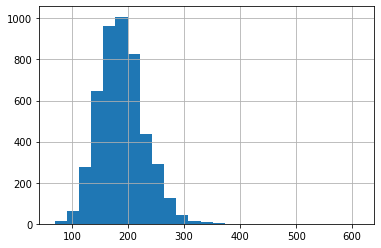

In [24]:
df.LBXTC.hist(bins=25)

The distribution is skewed.  There do appear to be outliers. As there are not many predictions above 350, it may make it hard to predict values in that range.  

Should I limit my LBXTC values below 350?
Should I use log transformed values?  

These are questions I need to answer

### Histograms of continuous variables

In [22]:
#need to still do outliers too